In [58]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.linear_model import LogisticRegression,RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import category_encoders as ce


from scipy.stats import randint, uniform
from scipy.stats import loguniform


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.impute import SimpleImputer

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_classif
)

from sklearn.svm import SVC



from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    log_loss,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score
)

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [60]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [61]:
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()



#### Numeric Pipeline

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.caps_ = {}

    def fit(self, X, y=None):
        # handle both DataFrame and array
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        for i, col in enumerate(X.columns):
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.caps_[i] = (Q1 - self.factor*IQR, Q3 + self.factor*IQR)  # store by index
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)
        X = X.copy()
        for i, col in enumerate(X.columns):
            lower, upper = self.caps_[i]
            X[col] = X[col].clip(lower, upper)
        return X.values  # return as array for compatibility


In [63]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.pipeline import FunctionTransformer
from sklearn.preprocessing import PowerTransformer


log_cols = ['owner_age']  # columns to apply log1p
yj_cols = ['business_expenses', 'personal_income', 'business_turnover', 'business_age_years']


# log1p pipeline
log_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log1p', FunctionTransformer(np.log1p, validate=True)),
    ('cap', OutlierCapper(factor=1.5)),
    ('scaler', MinMaxScaler())
])

yj_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('yeojohnson', PowerTransformer(method='yeo-johnson', standardize=False)),
    ('cap', OutlierCapper(factor=1.5)),
    ('scaler', MinMaxScaler())  # optional if needed
])

other_numeric_cols = [col for col in num_cols if col not in yj_cols]


other_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), #
    ('scaler', MinMaxScaler()) # try MinMaxScaler for logistic?
])


#### Categorical Pipeline

In [87]:
target_encode_cols = ['funeral_insurance', 'medical_insurance', 
            'motor_vehicle_insurance', 'has_credit_card', 'keeps_financial_records']  # replace with your chosen cols
onehot_cols = [c for c in cat_cols if c not in target_encode_cols]



# Target encoding pipeline
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.SumEncoder())
])



# One-hot encoding pipeline
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ('log_num', log_pipeline, log_cols),
        ('yj_num', yj_pipeline, yj_cols),
        ('num', other_num_pipeline, other_numeric_cols),
        ('target', target_pipeline, target_encode_cols),
        ('onehot', onehot_pipeline, onehot_cols)
    ],
    remainder='passthrough'
)


In [89]:
# Remove near-constant features
variance_filter = VarianceThreshold(threshold=0.01)


In [90]:
# Statistical feature selectio
feature_selector = SelectKBest(
    score_func=f_classif,
    k=300    # tuneable
)

# Full Pipline

In [ ]:
from sklearn.base import clone

def build_pipeline(model):
    """
    Wraps preprocessing + model in a single pipeline
    """
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('variance_filter', variance_filter),
        # ('feature_selection', feature_selector),
        ('model', model),

    ])
    return pipeline


In [94]:
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
from sklearn.neighbors import NearestCentroid, RadiusNeighborsClassifier
from sklearn.svm import SVC, NuSVC
from scipy.stats import loguniform
from sklearn.decomposition import PCA


base_models = {
    'logistic': {
        'model': LogisticRegression(
            solver='lbfgs',          # fastest + stable
            max_iter=1000,
            n_jobs=-1,
            class_weight='balanced'
        ),
        'params': {
            'model__C': [0.1, 1, 10],     # MOST important
            'model__fit_intercept': [True]
        }
    },
    'sgd': {
        'model': SGDClassifier(
            max_iter=2000,
            tol=1e-3,
            random_state=42
        ),
        'params': {
            'model__loss': ['log_loss', 'hinge'],
            'model__alpha': [1e-4, 1e-3, 1e-2],   # regularization strength
            'model__penalty': ['l2']
        }
    },
    'svm_rbf': {
        'model': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            'model__C': [1, 10],
            'model__gamma': ['scale', 0.01]
        }
    },
    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': [5, 15, 30],
            'model__weights': ['uniform', 'distance']
        }
    },
    # 'random_forest': {
    #     'model': RandomForestClassifier(
    #         random_state=42,
    #         n_jobs=-1,
    #         class_weight='balanced'
    #     ),
    #     'params': {
    #         'model__n_estimators': [100, 300],
    #         'model__max_depth': [None, 10],
    #         'model__max_features': ['sqrt']
    #     }
    # },
    # # 🌲 LightGBM
    # 'lightgbm': {
    #     'model': LGBMClassifier(
    #         random_state=42,
    #         n_jobs=-1,
    #         class_weight='balanced'
    #     ),
    #     'params': {
    #         'model__n_estimators': [100, 300, 500],
    #         'model__num_leaves': [31, 50, 70],
    #         'model__learning_rate': [0.05, 0.1, 0.2],
    #         'model__subsample': [0.8, 1.0],
    #         'model__colsample_bytree': [0.8, 1.0]
    #     }
    # },


}

# Dictionary of models + param grids
models = {
    'logistic': {
        'model': LogisticRegression(
            multi_class='multinomial',
            solver='saga',
            max_iter=5000,
            n_jobs=-1
        ),
        'params': {
            'model__C': loguniform(1e-3, 1e3),
            'model__penalty': ['l1', 'l2', 'elasticnet'],
            'model__fit_intercept': [True, False],
            'model__l1_ratio': [0, 0.5, 1]
        }
    },


        # 12️⃣ PCA + Logistic Regression pipeline
    # 'pca_logistic': {
    #     'model': Pipeline([
    #         ('pca', PCA()),
    #         ('logistic', LogisticRegression(
    #             multi_class='multinomial',
    #             solver='saga',
    #             max_iter=5000,
    #             n_jobs=-1
    #         ))
    #     ]),
    #     'params': {
    #         'pca__n_components': [5, 10, 15, 20],
    #         'logistic__C': loguniform(0.1, 100),
    #         'logistic__penalty': ['l1', 'l2', 'elasticnet'],
    #         'logistic__l1_ratio': [0, 0.5, 1]
    #     }
    # },
    # 'ridge': {
    #     'model': RidgeClassifier(),
    #     'params': {
    #         'model__alpha': loguniform(1e-3, 100)
    #     }
    # },

    'sgd': {
        'model': SGDClassifier(max_iter=5000, tol=1e-3, random_state=42),
        'params': {
            'model__loss': ['hinge', 'log', 'modified_huber'],
            'model__penalty': ['l2', 'l1', 'elasticnet'],
            'model__alpha': loguniform(1e-5, 1e-1)
        }
    },

       # --- Naive Bayes ---
    
    #----------------
    # Error
    #---------------
    # 'gaussian_nb': {
    #     'model': GaussianNB(),
    #     'params': {}
    # },

    # 'multinomial_nb': {
    #     'model': MultinomialNB(),
    #     'params': {'model__alpha':[0.1,0.5,1.0]}
    # },

    # 'bernoulli_nb': {
    #     'model': BernoulliNB(),
    #     'params': {'model__alpha':[0.1,0.5,1.0]}
    # },


    # 'passive_aggressive': {
    #     'model': PassiveAggressiveClassifier(max_iter=1000, random_state=42),
    #     'params': {'model__C': loguniform(0.1,10)
    #     }
    # },
    
    # -----------------
    # Error
    # -----------------
    # 'nusvc': {
    #     'model': NuSVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42),
    #     'params': {'model__nu':[0.2,0.4,0.6,0.8], 'model__gamma': loguniform(1e-3,0.1)}
    # },

    # 'complement_nb': {'model': ComplementNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},
    # -----------------
    # Error
    # -----------------
    # 'categorical_nb': {'model': CategoricalNB(), 'params': {'model__alpha':[0.1,0.5,1.0]}},


    'svm_rbf': {
        'model': SVC(
            kernel='rbf',
            probability=True,
            class_weight='balanced',
            random_state=42
        ),
        'params': {
            # 'model__C': loguniform(1e-2, 1e3), for wider range
            # 'model_gamma': loguniform(1e-4, 10), for wider range
            "model__C": loguniform(0.1, 100),
            "model__gamma": loguniform(1e-3, 0.1)
        }
    },

#------------------
# This was good model
#------------------

    # 'svm_poly': {
    #     'model': SVC(
    #         kernel='poly',
    #         probability=True,
    #         class_weight='balanced',
    #         random_state=42
    #     ),
    #     'params': {
    #         "model__C": loguniform(0.1, 100),          # regularization
    #         "model__degree": [2, 3],             # polynomial degree
    #         "model__gamma": loguniform(1e-3, 0.1),     # kernel width
    #         "model__coef0": [0, 0.1, 0.5, 1]           # independent term in poly kernel
    #     }
    # },


#------------------
# This was good model
#------------------
    # Too Much Time
    # 'svm_linear': {
    #     'model': SVC(
    #         kernel='linear',
    #         probability=True,
    #         class_weight='balanced',
    #         random_state=42
    #     ),
    #     'params': {
    #         'model__C': loguniform(0.1, 100) # loguniform(1e-2, 1e2)
    #     }
    # },

    # -----------------
    # Error
    # -----------------
    # 'svm_calibrated': {
    #     'model': CalibratedClassifierCV(estimator=SVC(probability=True, kernel='rbf', random_state=42)),
    #     'params': {
    #         'base_estimator__C': loguniform(0.1,100), 
    #         'base_estimator__gamma': loguniform(1e-3,0.1)
    #     }
    # },

    'knn': {
        'model': KNeighborsClassifier(),
        'params': {
            'model__n_neighbors': randint(3, 50),        # number of neighbors
            'model__weights': ['uniform', 'distance'],   # weighting function
            'model__p': [1, 2]                           # 1 = Manhattan, 2 = Euclidean
        },
    },

    # -----------------
    # Error
    # -----------------
    # 'radius_neighbors': {
    #     'model': RadiusNeighborsClassifier(),
    #     'params': {
    #         'model__radius':[0.5,1.0,2.0]
    #     }
    # },
    
    # 'nearest_centroid': {
    #     'model': NearestCentroid(),
    #     'params': {}
    # },


    # 'lda': {
    #     'model': LinearDiscriminantAnalysis(),
    #     'params': {
    #         'model__solver': ['svd', 'lsqr', 'eigen'],           # solver choices
    #         'model__shrinkage': [None, 'auto', 0.1, 0.5, 0.9]      # only used with lsqr/eigen
    #     }
    # },
#------------------
# Error
#------------------

    # 'kpca_lda': {   # <-- new pipeline entry
    #     'model': Pipeline([
    #         ('kpca', KernelPCA(random_state=42, fit_inverse_transform=False)),
    #         ('lda', LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'))
    #     ]),
    #     'params': {
    #         'kpca__n_components': [5, 10, 15, 30],
    #         'kpca__kernel': ['rbf', 'poly'],
    #         'kpca__gamma': [0.01, 0.05, 0.1],
    #         'kpca__degree': [2, 3],           # only used for poly
    #         'lda__shrinkage': ['auto', 0.1, 0.5]
    #     }
    # },
    

    # -----------------
    # Error
    # -----------------
    # 'qda': {
    #     'model': QuadraticDiscriminantAnalysis(),
    #     'params': {
    #         'model__reg_param': [0.0, 0.1, 0.5]  # regularization for QDA
    #     }
    # },






    # # 8️⃣ Random Forest
    'random_forest': {
        'model': RandomForestClassifier(
            random_state=42,
            n_jobs=-1
        ),
        'params': {
            'model__n_estimators': randint(100, 1000),
            'model__max_depth': [None, 5, 10, 20],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__max_features': ['sqrt', 'log2', None]
        }
    },

    # # 9️⃣ Gradient Boosting
    'gradient_boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': randint(100, 1000),
            'model__learning_rate': loguniform(0.01, 0.5),
            'model__max_depth': [3, 5, 7, 10],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__max_features': ['sqrt', 'log2', None]
        }
    },

    # 🔟 AdaBoost
    'adaboost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'model__n_estimators': randint(50, 500),
            'model__learning_rate': loguniform(0.01, 1.0)
        }
    },



    


}


In [95]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, log_loss,
    roc_auc_score, f1_score, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt




def train_and_evaluate(X_train, y_train, X_test, y_test, model_dict, n_iter=20, cv=5, plot_confusion=True, plot_importance=True):
    results = {}
    summary_list = []

    feature_names = X_train.columns.tolist()  # get column names for importance

    for name, cfg in model_dict.items():
        print(f"\n=== Training {name} ===")
        pipeline = build_pipeline(cfg['model'])

        search = RandomizedSearchCV(
            pipeline,
            param_distributions=cfg['params'],
            n_iter=n_iter,
            cv=cv,
            scoring='neg_log_loss',
            verbose=1,
            n_jobs=-1,
            random_state=42,
            refit=True
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Robust probability handling
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)
        else:
            y_proba = np.zeros((len(y_pred), len(np.unique(y_train))))
            for i, label in enumerate(y_pred):
                y_proba[i, label] = 1

        # Metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
            'log_loss': log_loss(y_test, y_proba),
            'roc_auc': roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted'),
            'f1_weighted': f1_score(y_test, y_pred, average='weighted')
        }

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        results[name] = {
            'best_model': best_model,
            'best_params': search.best_params_,
            'cv_score': search.best_score_,
            'metrics': metrics,
            'confusion_matrix': cm
        }

        # Add summary row
        summary_list.append({
            'Model': name,
            'CV Score': search.best_score_,
            'Accuracy': metrics['accuracy'],
            'Balanced Accuracy': metrics['balanced_accuracy'],
            'Log Loss': metrics['log_loss'],
            'ROC AUC': metrics['roc_auc'],
            'F1 Weighted': metrics['f1_weighted']
        })

        print(f"Best params: {search.best_params_}")
        print(f"Metrics: {metrics}")

        # Plot confusion matrix
        if plot_confusion:
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.title(f'Confusion Matrix: {name}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()




    # Summary table
    summary_df = pd.DataFrame(summary_list)
    summary_df = summary_df.sort_values(by='ROC AUC', ascending=False)
    print("\n=== Summary Table ===")
    display(summary_df)

    return results, summary_df



=== Training logistic ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits


Best params: {'model__fit_intercept': True, 'model__C': 1}
Metrics: {'accuracy': 0.8248440748440748, 'balanced_accuracy': 0.8016882002934214, 'log_loss': 0.3997237509343831, 'roc_auc': 0.9272276411016962, 'f1_weighted': 0.8284073894680156}


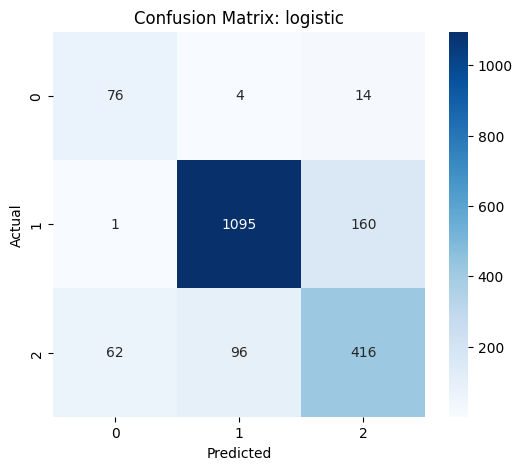


=== Training sgd ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__penalty': 'l2', 'model__loss': 'log_loss', 'model__alpha': 0.001}
Metrics: {'accuracy': 0.83991683991684, 'balanced_accuracy': 0.6757071972932573, 'log_loss': 0.3976496397247101, 'roc_auc': 0.9180400415366549, 'f1_weighted': 0.8254875193505916}


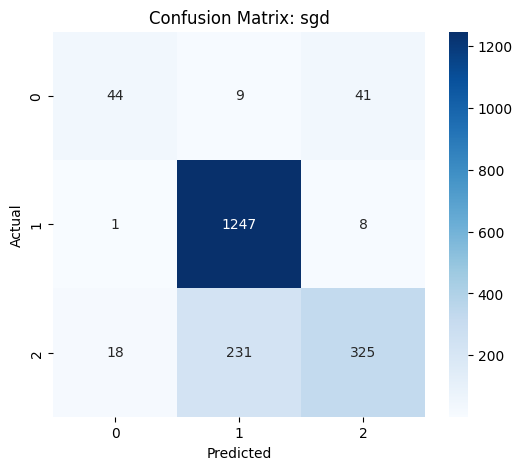


=== Training svm_rbf ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'model__gamma': 'scale', 'model__C': 10}
Metrics: {'accuracy': 0.8523908523908524, 'balanced_accuracy': 0.7874219954955827, 'log_loss': 0.352159674246825, 'roc_auc': 0.9356151674437234, 'f1_weighted': 0.853333213240938}


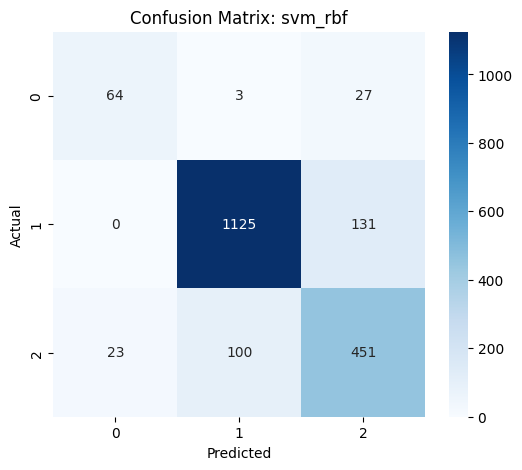


=== Training knn ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__weights': 'distance', 'model__n_neighbors': 30}
Metrics: {'accuracy': 0.8108108108108109, 'balanced_accuracy': 0.5930237801690739, 'log_loss': 0.684945746480787, 'roc_auc': 0.9020715318734853, 'f1_weighted': 0.791826539006784}


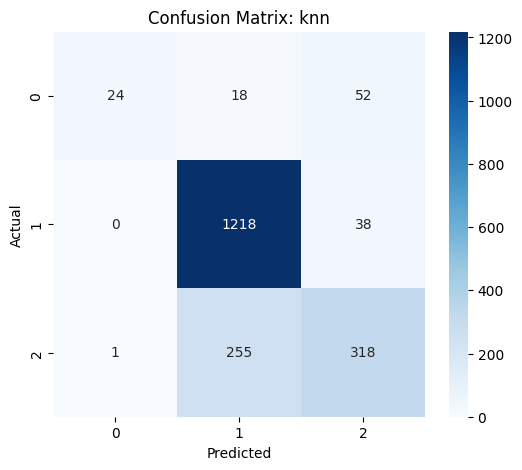


=== Summary Table ===


,Model,CV Score,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
2,svm_rbf,-0.353492,0.852391,0.787422,0.352160,0.935615,0.853333
0,logistic,-0.415781,0.824844,0.801688,0.399724,0.927228,0.828407
1,sgd,-0.391832,0.839917,0.675707,0.397650,0.918040,0.825488
3,knn,-0.647542,0.810811,0.593024,0.684946,0.902072,0.791827


In [71]:
# train all models
# model_dict={'sgd': models['sgd'], 'logistic': models['logistic']}
results = train_and_evaluate(X_train, y_train_enc, X_test, y_test_enc, base_models)



=== Training logistic ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'model__fit_intercept': True, 'model__C': 1}
Metrics: {'accuracy': 0.8253638253638254, 'balanced_accuracy': 0.803972990337806, 'log_loss': 0.39698107642959374, 'roc_auc': 0.9284335929400718, 'f1_weighted': 0.8284640413412773}


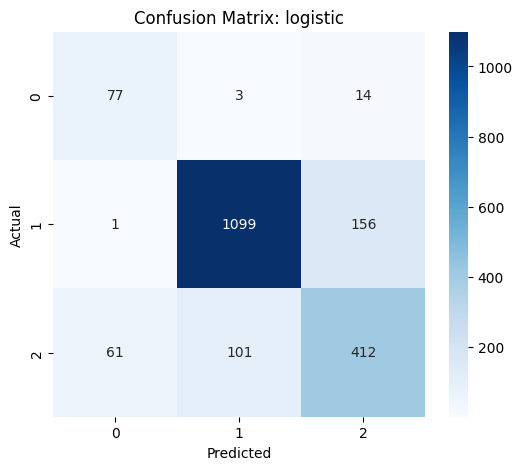


=== Training sgd ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__penalty': 'l2', 'model__loss': 'log_loss', 'model__alpha': 0.001}
Metrics: {'accuracy': 0.840956340956341, 'balanced_accuracy': 0.6857647750726826, 'log_loss': 0.3979100338896878, 'roc_auc': 0.9180122711871508, 'f1_weighted': 0.8267889383380059}


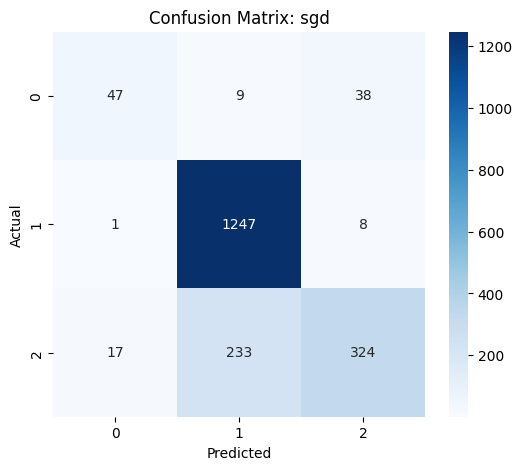


=== Training svm_rbf ===
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params: {'model__gamma': 'scale', 'model__C': 10}
Metrics: {'accuracy': 0.8555093555093555, 'balanced_accuracy': 0.7962064198256061, 'log_loss': 0.35258200755880664, 'roc_auc': 0.9359125463405429, 'f1_weighted': 0.8565667527127698}


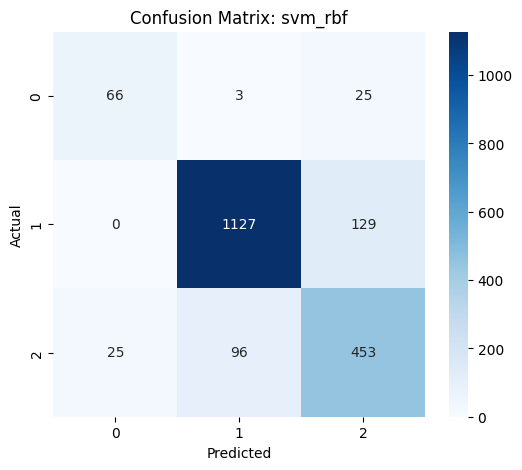


=== Training knn ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params: {'model__weights': 'distance', 'model__n_neighbors': 30}
Metrics: {'accuracy': 0.8097713097713097, 'balanced_accuracy': 0.5993697349369677, 'log_loss': 0.6828267052590151, 'roc_auc': 0.9036187607403372, 'f1_weighted': 0.7918227534872775}


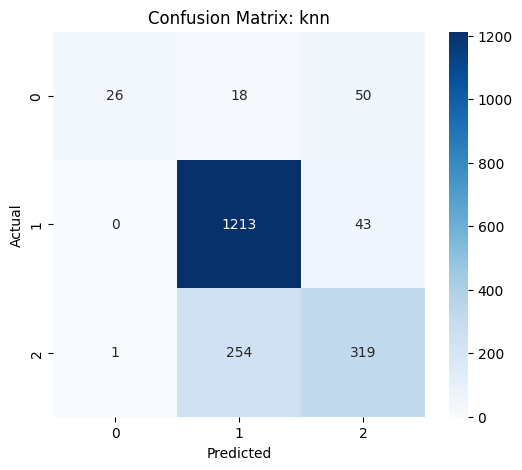


=== Summary Table ===


,Model,CV Score,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
2,svm_rbf,-0.351952,0.855509,0.796206,0.352582,0.935913,0.856567
0,logistic,-0.414267,0.825364,0.803973,0.396981,0.928434,0.828464
1,sgd,-0.391083,0.840956,0.685765,0.397910,0.918012,0.826789
3,knn,-0.645412,0.809771,0.599370,0.682827,0.903619,0.791823


In [ ]:
# train all models
# model_dict={'sgd': models['sgd'], 'logistic': models['logistic']}
results = train_and_evaluate(X_train, y_train_enc, X_test, y_test_enc, base_models)


### with one-hot only


=== Training logistic ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best params: {'model__C': 1.319496149042566, 'model__fit_intercept': False, 'model__l1_ratio': 0.5, 'model__penalty': 'l1'}
Metrics: {'accuracy': 0.8664241164241164, 'balanced_accuracy': 0.7511263797709512, 'log_loss': 0.3384450624242216, 'roc_auc': 0.9348558181116834, 'f1_weighted': 0.8596034968723975}


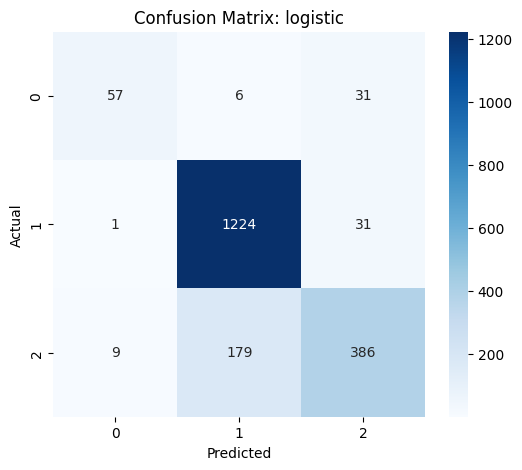


=== Training sgd ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__alpha': 0.0027541439213320286, 'model__loss': 'modified_huber', 'model__penalty': 'elasticnet'}
Metrics: {'accuracy': 0.8341995841995842, 'balanced_accuracy': 0.6254692429264138, 'log_loss': 0.9699747581436909, 'roc_auc': 0.8959802702873526, 'f1_weighted': 0.8169166037908799}


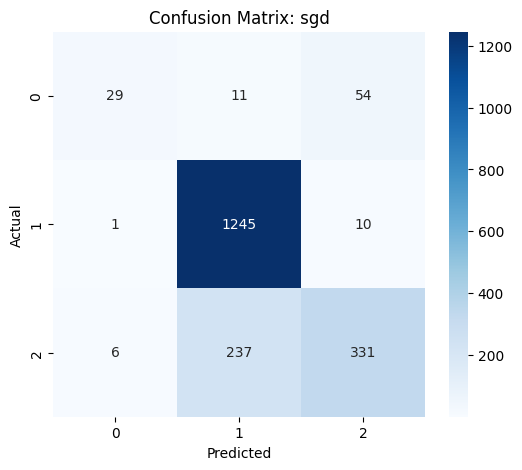


=== Training multinomial_nb ===
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params: {'model__alpha': 1.0}
Metrics: {'accuracy': 0.5867983367983368, 'balanced_accuracy': 0.6499338574058693, 'log_loss': 1.9466160877362149, 'roc_auc': 0.803629932440917, 'f1_weighted': 0.6393948206819411}


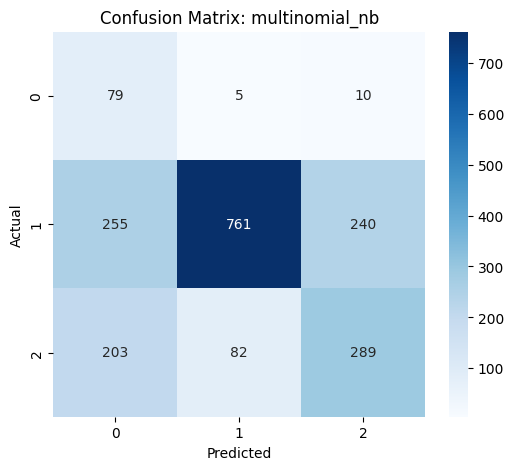


=== Training svm_rbf ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__C': 15.702970884055382, 'model__gamma': 0.015751320499779724}
Metrics: {'accuracy': 0.8471933471933472, 'balanced_accuracy': 0.8053982886739987, 'log_loss': 0.3545375325437887, 'roc_auc': 0.9359284140102829, 'f1_weighted': 0.8495891265478878}


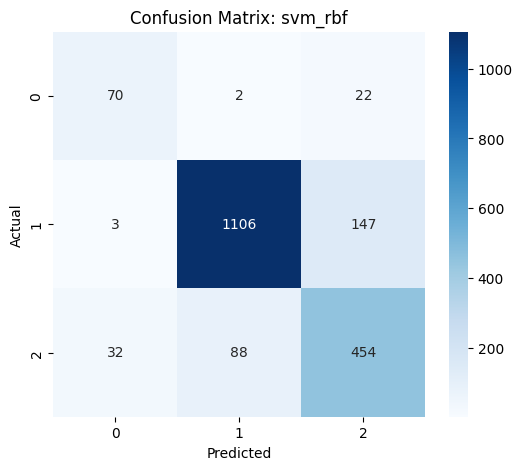


=== Training knn ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__n_neighbors': 49, 'model__p': 2, 'model__weights': 'uniform'}
Metrics: {'accuracy': 0.7707900207900208, 'balanced_accuracy': 0.5125358887220993, 'log_loss': 0.6091447103389632, 'roc_auc': 0.876047735482309, 'f1_weighted': 0.7369039651552686}


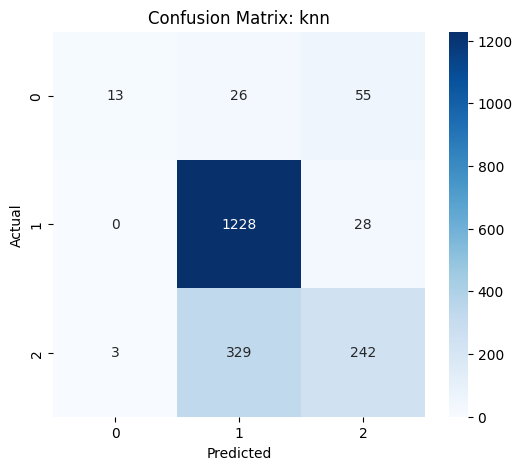


=== Training random_forest ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__max_depth': 10, 'model__max_features': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 351}
Metrics: {'accuracy': 0.8773388773388774, 'balanced_accuracy': 0.7629457138859234, 'log_loss': 0.31554603186345254, 'roc_auc': 0.9422171926137765, 'f1_weighted': 0.8699868426912488}


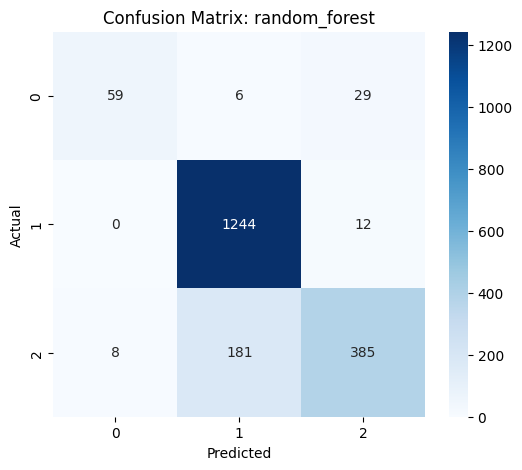


=== Training gradient_boosting ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__learning_rate': 0.0432845022129388, 'model__max_depth': 3, 'model__max_features': None, 'model__n_estimators': 206, 'model__subsample': 0.6}
Metrics: {'accuracy': 0.8768191268191268, 'balanced_accuracy': 0.7544148381342098, 'log_loss': 0.3212042793401188, 'roc_auc': 0.9410462189693072, 'f1_weighted': 0.8696008106436827}


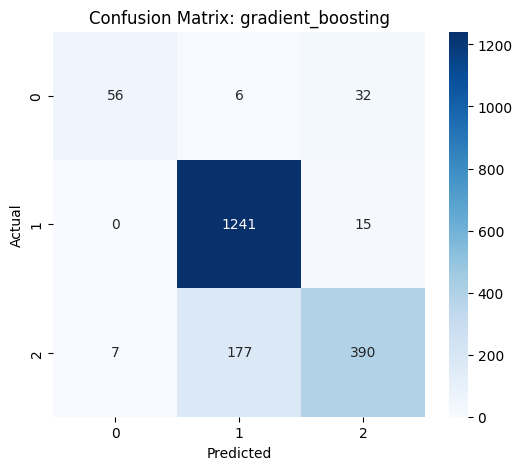


=== Training adaboost ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'model__learning_rate': 0.011120513715710632, 'model__n_estimators': 108}
Metrics: {'accuracy': 0.7806652806652806, 'balanced_accuracy': 0.4761904761904762, 'log_loss': 0.8305685827295468, 'roc_auc': 0.695102265996543, 'f1_weighted': 0.7374306041815539}


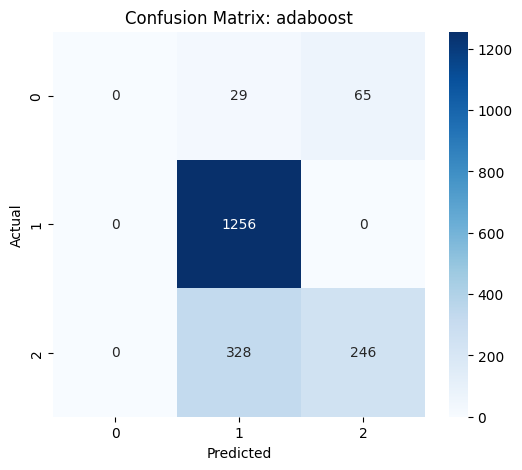


=== Summary Table ===


,Model,CV Score,Accuracy,Balanced Accuracy,Log Loss,ROC AUC,F1 Weighted
5,random_forest,-0.309311,0.877339,0.762946,0.315546,0.942217,0.869987
6,gradient_boosting,-0.317122,0.876819,0.754415,0.321204,0.941046,0.869601
3,svm_rbf,-0.353681,0.847193,0.805398,0.354538,0.935928,0.849589
0,logistic,-0.334385,0.866424,0.751126,0.338445,0.934856,0.859603
1,sgd,-0.693913,0.834200,0.625469,0.969975,0.895980,0.816917
4,knn,-0.594522,0.770790,0.512536,0.609145,0.876048,0.736904
2,multinomial_nb,-1.836401,0.586798,0.649934,1.946616,0.803630,0.639395
7,adaboost,-0.825344,0.780665,0.476190,0.830569,0.695102,0.737431


In [ ]:
# train all models
# model_dict={'sgd': models['sgd'], 'logistic': models['logistic']}
results = train_and_evaluate(X_train, y_train_enc, X_test, y_test_enc, models)
